# Get test metrics: Multi-GPU trained model

for CIFAR-10 dataset

In [1]:
# Specify GPU to be used-
# %env CUDA_VISIBLE_DEVICES = 0, 1
%env CUDA_VISIBLE_DEVICES = 2

env: CUDA_VISIBLE_DEVICES=2


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
import torchvision

from ResNet18_swish_torch import ResNet18
import torchvision.transforms as transforms

from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
import numpy as np
import os, pickle

In [3]:
print(f"torch version: {torch.__version__}")

# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")

# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is {device}')

torch version: 2.0.1+cu117
Number of GPU(s) available = 1
Current GPU: 0
Current GPU name: NVIDIA GeForce GTX 1080 Ti
Available device is cuda


In [9]:
batch_size = 256

In [10]:
'''
# Define transformations for training and test sets-
transform_train = transforms.Compose(
    [
      transforms.RandomCrop(32, padding = 4),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize(
        mean = (0.4914, 0.4822, 0.4465),
        std = (0.0305, 0.0296, 0.0342)),
     ]
)
'''
transform_test = transforms.Compose(
    [
      transforms.ToTensor(),
      transforms.Normalize(
        mean = (0.4942, 0.4846, 0.4498),
        std = (0.0304, 0.0295, 0.0342)),
     ]
)

'''
train_dataset = torchvision.datasets.CIFAR10(
    root = './data', train = True,
    download = True, transform = transform_train
)
'''

test_dataset = torchvision.datasets.CIFAR10(
    root = '/home/majumdar/Downloads/.data/', train = False,
    download = True, transform = transform_test
)

'''
train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset, batch_size = 256,
    shuffle = True
    )
'''
test_loader = torch.utils.data.DataLoader(
    dataset = test_dataset, batch_size = 256,
    shuffle = True
    )
 

Files already downloaded and verified


In [11]:
# Define loss function and optimizer-
loss = nn.CrossEntropyLoss()

# optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr = 0.0, momentum = 0.9, weight_decay = 5e-4)

In [12]:

"""
def test_model_progress(model, test_loader, test_dataset):
    running_loss_test = 0.0

    # Set model to evaluation mode-
    model.eval()        

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)
                
            
            # Predict using trained model-
            outputs = model(images)
            # _, y_pred = torch.max(outputs, 1)
                
            # Compute test loss-
            J_test = loss(outputs, labels)
                
            running_loss_test += J_test.item() * labels.size(0)

            # Compute torchmetrics on current batch/step-
            acc_test = test_acc_metric(outputs, labels)
            acc_test = test_acc_metric.update(outputs, labels)
            print(f"acc batch = {acc_test:.3f}")
        
    # return (running_loss_val, correct, total)
    test_loss_epoch = running_loss_test / len(test_dataset)

    # Compute torchmetrics on all batches using custom accumulation-
    test_acc_epoch = test_acc_metric.compute() * 100

    # Rest metric-
    test_acc_metric.reset()

    print(
        f"{'-' * 90}\n(Test) Steps: {len(test_loader)} | Loss: {test_loss_epoch:.4f} | Acc: {test_acc_epoch:.2f}%",
        flush = True,
    )

    return test_loss_epoch, test_acc_epoch
"""

def test_model_progress(model, test_loader, test_dataset):
    total = 0.0
    correct = 0.0
    running_loss_val = 0.0

    with torch.no_grad():
        with tqdm(test_loader, unit = 'batch') as tepoch:
            for images, labels in tepoch:
                tepoch.set_description(f"Validation: ")
                
                images = images.to(device)
                labels = labels.to(device)
                
                # Set model to evaluation mode-
                model.eval()
            
                # Predict using trained model-
                outputs = model(images)
                _, y_pred = torch.max(outputs, 1)
                
                # Compute validation loss-
                J_val = loss(outputs, labels)
                
                running_loss_val += J_val.item() * labels.size(0)
    
                # Total number of labels-
                total += labels.size(0)

                # Total number of correct predictions-
                correct += (y_pred == labels).sum()
                
                tepoch.set_postfix(
                    val_loss = running_loss_val / len(test_dataset),
                    val_acc = 100 * (correct.cpu().numpy() / total)
                )
            
        
    # return (running_loss_val, correct, total)
    val_loss = running_loss_val / len(test_dataset)
    val_acc = (correct / total) * 100

    return val_loss, val_acc.cpu().numpy()


In [13]:
# Initialize and load trained model parameters-
trained_model = ResNet18(beta = 1.0).to(device)

In [14]:
# Multi-GPU trained model-
loaded_state = torch.load("ResNet18_CIFAR10_multigpu-best_testacc.pth", map_location = 'cuda:0')
trained_model.load_state_dict(loaded_state)
                          
# Single-GPU trained model-
# trained_model.load_state_dict(torch.load("ResNet18_lastepoch.pth"))
# trained_model.load_state_dict(torch.load("ResNet18_best_testacc_model.pth"))

<All keys matched successfully>

In [15]:
# Get validation loss and accuracy-
test_loss, test_acc = test_model_progress(trained_model, test_loader, test_dataset)
# print(f"ResNet-18 'best' model metrics: val_loss = {test_loss:.4f} & test_acc = {test_acc:.3f}%")

Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.64batch/s, val_acc=86.9, val_loss=0.438]


In [16]:
print(f"ResNet-18 (multi-gpu DDP) test metrics; loss = {test_loss:.4f} & acc = {test_acc:.2f}%")

ResNet-18 (multi-gpu DDP) test metrics; loss = 0.4378 & acc = 86.87%


In [17]:
print(f"trained beta = {trained_model.beta.item():.4f}")

trained beta = 4.5128


In [4]:
import pickle

with open("ResNet18_CIFAR10_swish_train_history.pkl", "rb") as file:
    train_hist = pickle.load(file)

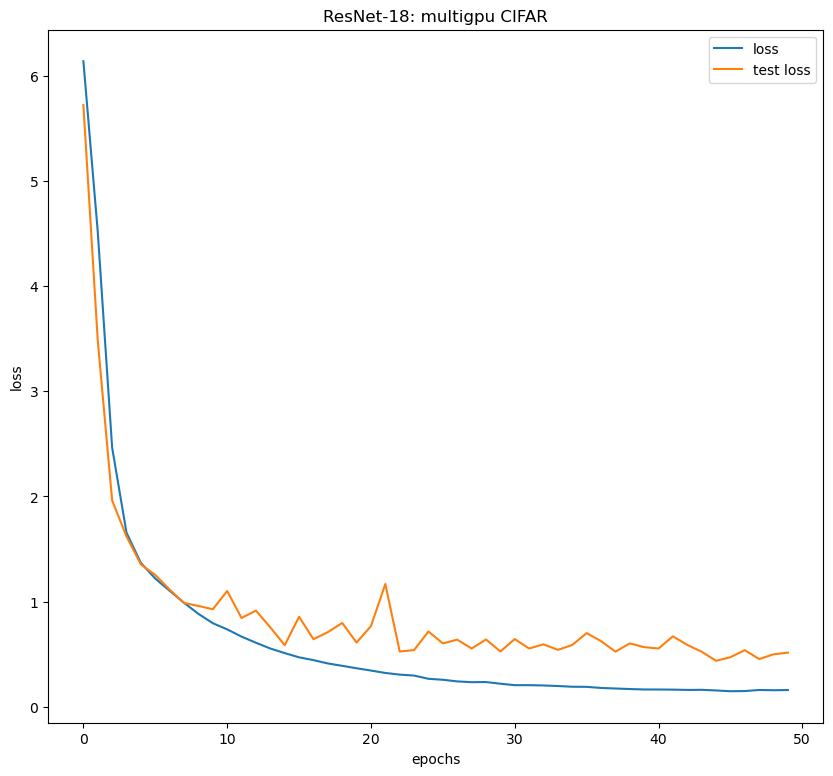

In [6]:
plt.figure(figsize = (10, 9))
plt.plot([train_hist[k]['loss'] for k in train_hist.keys()], label = 'loss')
plt.plot([train_hist[k]['test_loss'] for k in train_hist.keys()], label = 'test loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("ResNet-18: multigpu CIFAR")
plt.show()

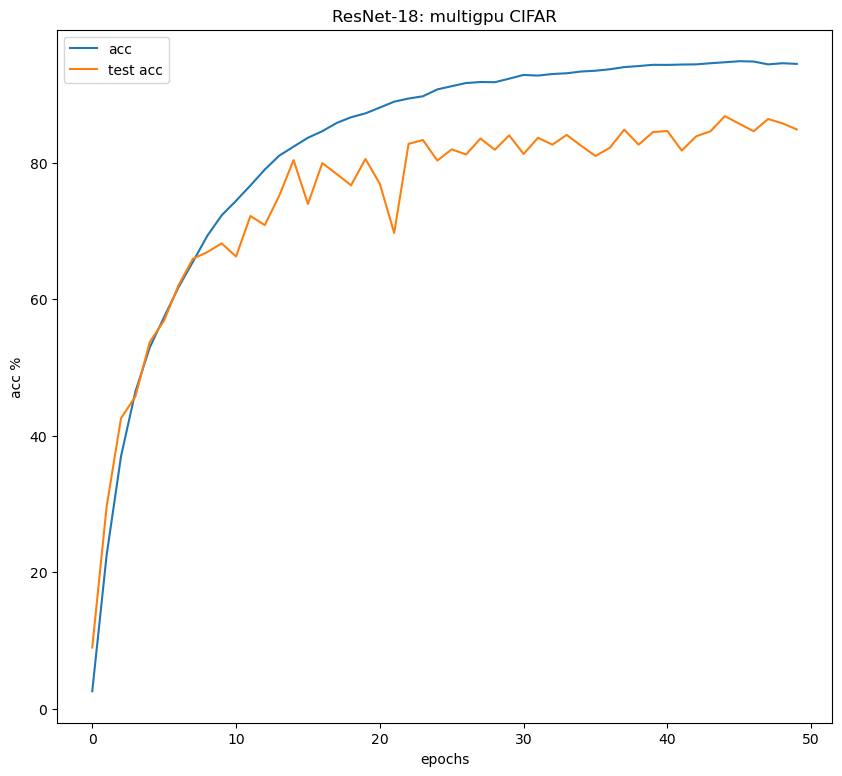

In [7]:
plt.figure(figsize = (10, 9))
plt.plot([train_hist[k]['acc'] for k in train_hist.keys()], label = 'acc')
plt.plot([train_hist[k]['test_acc'] for k in train_hist.keys()], label = 'test acc')
plt.xlabel("epochs")
plt.ylabel("acc %")
plt.legend(loc = 'best')
plt.title("ResNet-18: multigpu CIFAR")
plt.show()

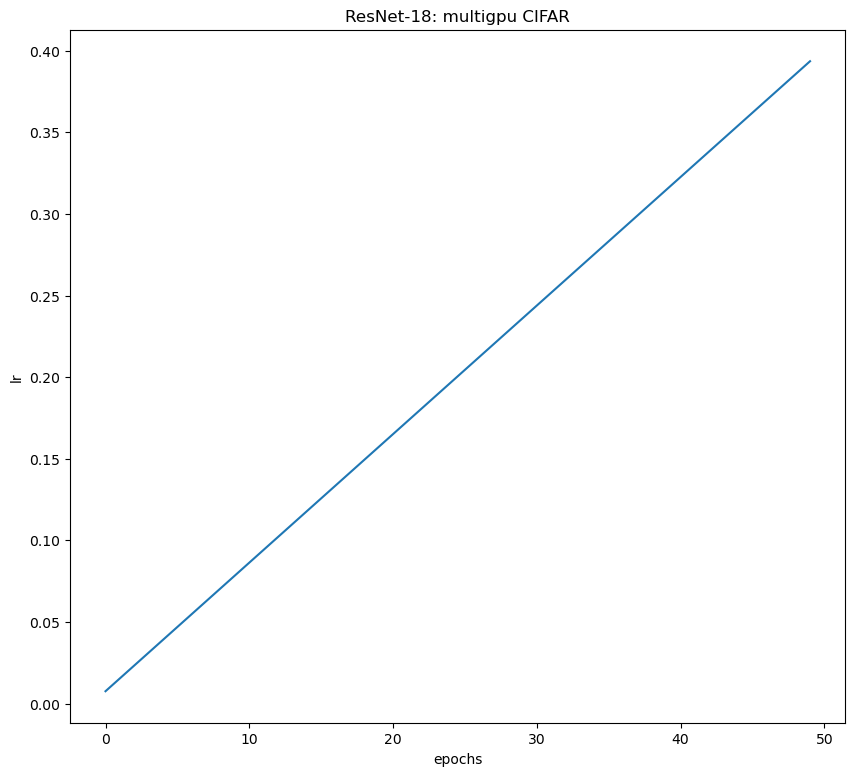

In [8]:
plt.figure(figsize = (10, 9))
plt.plot([train_hist[k]['lr'] for k in train_hist.keys()])
plt.xlabel("epochs")
plt.ylabel("lr")
plt.title("ResNet-18: multigpu CIFAR")
plt.show()

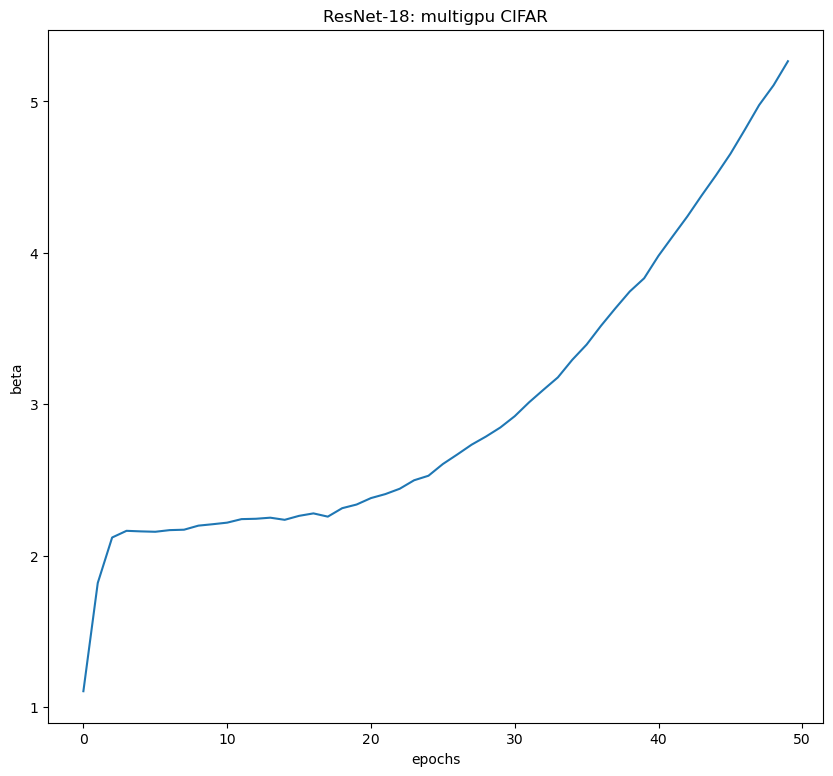

In [18]:
plt.figure(figsize = (10, 9))
plt.plot([train_hist[k]['beta'] for k in train_hist.keys()])
plt.xlabel("epochs")
plt.ylabel("beta")
plt.title("ResNet-18: multigpu CIFAR")
plt.show()